# Regressão Imobiliária

Este notebook implementa um pipeline de regressão usando uma rede neural construída com JAX. O modelo prevê preços de imóveis com base em características do conjunto de dados de mercado imobiliário.

Dataset source: [Housing Prices Regression Dataset on Kaggle](https://www.kaggle.com/datasets/denkuznetz/housing-prices-regression/data)

## Importação de bibliotecas
- `jax.numpy` para operações vetorizadas com JAX.
- `matplotlib.pyplot` para visualizações.
- `numpy` e `pandas` para manipulação de dados.
- `r2_score` do scikit-learn para avaliar desempenho.
- `train_test_split` para particionar dados.
- `ann` para funções de rede neural.

In [3]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

import ann

## Carregamento e preparação dos dados
- Lê o CSV do conjunto de dados.
- Separa as features (`X_df`) removendo `ID` e `Price`.
- Extrai o vetor de preços (`y`) e coloca em formato de matriz.

In [ ]:
df = pd.read_csv("datasets/real_estate_dataset.csv")

X_df = df.drop(columns=["ID", "Price"])
y = df["Price"].to_numpy().reshape(1, -1)
X = X_df.values.T

## Pré-processamento
- Normalização min-max de cada feature de entrada.
- Normalização do alvo (preço) para faixa [0,1].

In [5]:
X_min = X.min(axis=1, keepdims=True)
X_max = X.max(axis=1, keepdims=True)
X_norm = (X - X_min) / (X_max - X_min + 1e-8)
y_min = y.min()
y_max = y.max()
y_norm = (y - y_min) / (y_max - y_min + 1e-8)

## Divisão treino-teste
- 80% dos dados para treino e 20% para teste.
- Usa `train_test_split` com `random_state=1` para reprodutibilidade.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_norm.T, y_norm.T, test_size=0.2, random_state=1
)
X_train = jnp.array(X_train.T)
X_test = jnp.array(X_test.T)
y_train = jnp.array(y_train.T)
y_test = jnp.array(y_test.T)

print("Shapes de treino:", X_train.shape, y_train.shape)

Shapes de treino: (10, 400) (1, 400)


## Treinamento da rede neural

- Arquitetura: Entrada → 32 neurônios ocultos → 1 saída.
- Ativação oculta: ReLU
- Ativação de saída: Linear
- Função de erro: Erro quadrático médio (MSE)
- Taxa de aprendizado: 0.05
- Número de épocas: 2000

In [7]:
params = ann.treinar_rede(
    matriz_entrada=X_train,
    matriz_rotulos=y_train,
    dimensoes_camadas=(
        X_train.shape[0],
        32,
        1
    ),
    nome_ativacao_oculta="relu",
    nome_ativacao_saida="linear",
    nome_funcao_erro="erro_mse",
    taxa_aprendizado=0.05,
    numero_epocas=2000,
    verbose=True
)

Época  200/2000 - erro: 0.011967
Época  400/2000 - erro: 0.006615
Época  600/2000 - erro: 0.004633
Época  800/2000 - erro: 0.003640
Época 1000/2000 - erro: 0.003063
Época 1200/2000 - erro: 0.002675
Época 1400/2000 - erro: 0.002393
Época 1600/2000 - erro: 0.002175
Época 1800/2000 - erro: 0.001997
Época 2000/2000 - erro: 0.001853


## Predição
- Gera previsões normalizadas para treino e teste.

In [8]:
y_pred_train = ann.prever(
    X_train, params, nome_ativacao_oculta="relu", nome_ativacao_saida="linear"
)
y_pred_test = ann.prever(
    X_test, params, nome_ativacao_oculta="relu", nome_ativacao_saida="linear"
)

## Denormalização dos resultados
- Converte as previsões normalizadas de volta para valores reais de preço.

In [9]:
y_pred_train_real = np.array(y_pred_train) * (y_max - y_min) + y_min
y_train_real      = np.array(y_train)      * (y_max - y_min) + y_min
y_pred_test_real  = np.array(y_pred_test)  * (y_max - y_min) + y_min
y_test_real       = np.array(y_test)       * (y_max - y_min) + y_min

## Avaliação de desempenho
- Calcula RMSE (unidade real) e R² para treino e teste.

In [10]:
mse_train  = np.mean((y_pred_train_real - y_train_real) ** 2)
mse_test   = np.mean((y_pred_test_real  - y_test_real)  ** 2)

rmse_train = np.sqrt(mse_train)
rmse_test  = np.sqrt(mse_test)

r2_train = r2_score(y_train_real.flatten(),     y_pred_train_real.flatten())
r2_test  = r2_score(y_test_real.flatten(),      y_pred_test_real.flatten())

print(f"RMSE real treino: {rmse_train:.2f}  # (unidade $)")
print(f"RMSE real teste:  {rmse_test:.2f}  # (unidade $)")
print(f"R² treino:         {r2_train:.4f}")
print(f"R² teste:          {r2_test:.4f}")

RMSE real treino: 29425.64  # (unidade $)
RMSE real teste:  33778.90  # (unidade $)
R² treino:         0.9425
R² teste:          0.9190


## Visualização: Real vs. Predito
- Gráfico de dispersão comparando preços reais e previstos no conjunto de teste.

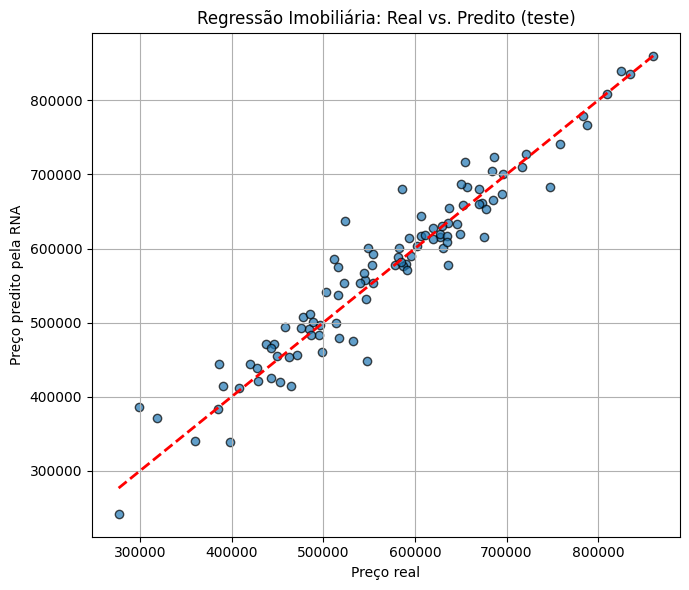

In [11]:
plt.figure(figsize=(7, 6))
plt.scatter(y_test_real.flatten(), y_pred_test_real.flatten(), alpha=0.7, edgecolor="k")
plt.plot(
    [y_test_real.min(), y_test_real.max()],
    [y_test_real.min(), y_test_real.max()],
    "r--",
    lw=2,
)
plt.xlabel("Preço real")
plt.ylabel("Preço predito pela RNA")
plt.title("Regressão Imobiliária: Real vs. Predito (teste)")
plt.grid(True)
plt.tight_layout()
plt.savefig("real_vs_predito.png", dpi=150)